In [1]:
import nest
import pandas as pd
import sys
import time
from tinydb import TinyDB, Query
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
client_id = '747bc52b-a233-4f6e-8897-d8024825cafa'
client_secret = 'aBjNY0fqY31Jeiy1MT1lGE857'
access_token_cache_file = 'nest.json'

napi = nest.Nest(client_id=client_id, client_secret=client_secret, access_token_cache_file=access_token_cache_file)

if napi.authorization_required:
    print('Go to ' + napi.authorize_url + ' to authorize, then enter PIN below')
    if sys.version_info[0] < 3:
        pin = raw_input("PIN: ")
    else:
        pin = input("PIN: ")
    napi.request_token(pin)

In [2]:
structure = napi.structures[0]
devices = structure.thermostats

ignores = ['structure', 'where_id', 'serial', 'device_id']


<IPython.core.display.Javascript object>


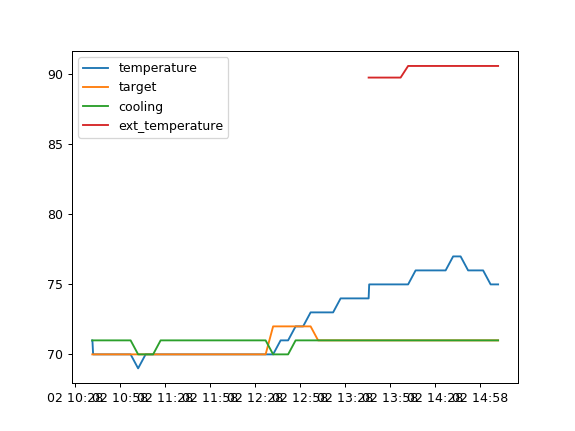

<IPython.core.display.Javascript object>


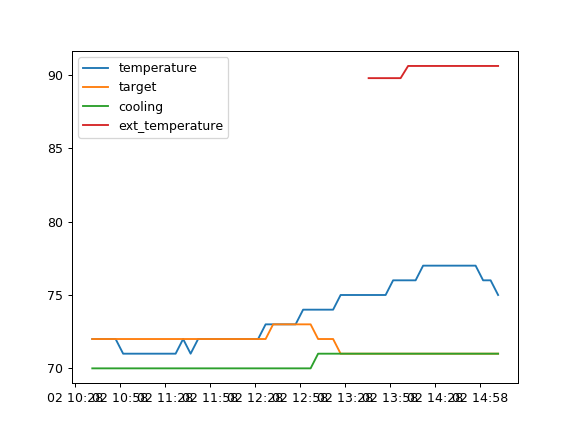

In [49]:
db = TinyDB('db.json')

df = pd.DataFrame(db.all())
df.last_connection = pd.to_datetime(df.last_connection)
df.request_time = pd.to_datetime(df.request_time)

df['cooling'] = df.hvac_state == 'cooling'

for name in ['Upstairs', 'Downstairs']:
    plt.figure()

    pdf = df[df.name == name]
    plt.plot(pdf.request_time, pdf.temperature)
    plt.plot(pdf.request_time, pdf.target)
    plt.plot(pdf.request_time, pdf.cooling + 70)
    plt.plot(pdf.request_time, pdf.ext_temperature)
    plt.legend()

In [8]:
# df = pd.DataFrame()

# n=0
# while n < 20:

#     for device in devices:
#         props = {}
#         for prop in dir(device):
#             if prop[0] != '_' and prop not in ignores:
#                 try:
#                     props[prop] = getattr(device, prop)

#                 except NotImplementedError:
#                     pass

#         df = df.append(props, ignore_index=True)

#         print('Current Temp:', device.temperature, 'Entries:', df.shape[0])
    
#     time.sleep(1800)
    
#     n += 1
    
# df

Current Temp: 71 Entries: 1
Current Temp: 72 Entries: 2
Current Temp: 70 Entries: 3
Current Temp: 72 Entries: 4
Current Temp: 70 Entries: 5
Current Temp: 71 Entries: 6
Current Temp: 69 Entries: 7
Current Temp: 71 Entries: 8
Current Temp: 69 Entries: 9
Current Temp: 70 Entries: 10
Current Temp: 69 Entries: 11
Current Temp: 70 Entries: 12
Current Temp: 69 Entries: 13
Current Temp: 71 Entries: 14
Current Temp: 69 Entries: 15
Current Temp: 70 Entries: 16
Current Temp: 70 Entries: 17
Current Temp: 72 Entries: 18
Current Temp: 69 Entries: 19
Current Temp: 70 Entries: 20
Current Temp: 68 Entries: 21
Current Temp: 70 Entries: 22
Current Temp: 69 Entries: 23
Current Temp: 71 Entries: 24
Current Temp: 69 Entries: 25
Current Temp: 71 Entries: 26
Current Temp: 69 Entries: 27
Current Temp: 70 Entries: 28
Current Temp: 69 Entries: 29
Current Temp: 71 Entries: 30
Current Temp: 68 Entries: 31
Current Temp: 70 Entries: 32
Current Temp: 69 Entries: 33
Current Temp: 71 Entries: 34
Current Temp: 69 Entrie

,can_cool,can_heat,description,eco_temperature,fan,fan_timer,has_dehumidifier,has_fan,has_hot_water_control,has_humidifier,...,mode,name,name_long,online,postal_code,previous_mode,target,temperature,temperature_scale,where
0,1.0,1.0,Upstairs Thermostat,"(55, 76)",1.0,15.0,None,1.0,None,None,...,cool,Upstairs,Upstairs Thermostat,1.0,None,,69.0,71.0,F,Upstairs
1,1.0,1.0,Downstairs Thermostat,"(55, 77)",1.0,15.0,None,1.0,None,None,...,cool,Downstairs,Downstairs Thermostat,1.0,None,,70.0,72.0,F,Downstairs
2,1.0,1.0,Upstairs Thermostat,"(55, 76)",1.0,15.0,None,1.0,None,None,...,cool,Upstairs,Upstairs Thermostat,1.0,None,,69.0,70.0,F,Upstairs
3,1.0,1.0,Downstairs Thermostat,"(55, 77)",0.0,15.0,None,1.0,None,None,...,cool,Downstairs,Downstairs Thermostat,1.0,None,,73.0,72.0,F,Downstairs
4,1.0,1.0,Upstairs Thermostat,"(55, 76)",1.0,15.0,None,1.0,None,None,...,cool,Upstairs,Upstairs Thermostat,1.0,None,,69.0,70.0,F,Upstairs
5,1.0,1.0,Downstairs Thermostat,"(55, 77)",0.0,15.0,None,1.0,None,None,...,cool,Downstairs,Downstairs Thermostat,1.0,None,,73.0,71.0,F,Downstairs
6,1.0,1.0,Upstairs Thermostat,"(55, 76)",1.0,15.0,None,1.0,None,None,...,cool,Upstairs,Upstairs Thermostat,1.0,None,,69.0,69.0,F,Upstairs
7,1.0,1.0,Downstairs Thermostat,"(55, 77)",0.0,15.0,None,1.0,None,None,...,cool,Downstairs,Downstairs Thermostat,1.0,None,,73.0,71.0,F,Downstairs
8,1.0,1.0,Upstairs Thermostat,"(55, 76)",1.0,15.0,None,1.0,None,None,...,cool,Upstairs,Upstairs Thermostat,1.0,None,,69.0,69.0,F,Upstairs
9,1.0,1.0,Downstairs Thermostat,"(55, 77)",0.0,15.0,None,1.0,None,None,...,cool,Downstairs,Downstairs Thermostat,1.0,None,,73.0,70.0,F,Downstairs


In [10]:
import datetime

In [12]:
now = datetime.datetime.now()

In [14]:
now.strftime('%c')

'Sat Sep  2 10:37:22 2017'

In [45]:
import pyowm

owm = pyowm.OWM(API_key='9c1add868b3c394269fe9c2059d99dad')  # You MUST provide a valid API key

observation = owm.weather_at_place('Cedar Park, TX')
w = observation.get_weather()

# Weather details
props['ext_wind'] = w.get_wind()                  # {'speed': 4.6, 'deg': 330}
props['ext_humidity'] = w.get_humidity()              # 87
props['ext_temperature'] = w.get_temperature('fahrenheit')  # {'temp_max': 10.5, 'temp': 9.7, 'temp_min': 9.0}
props['ext_heat_index'] = w.get_heat_index()
props['ext_rain'] = w.get_rain()
props['ext_status'] = w.get_detailed_status()



'Clear'

In [35]:
w.get_temperature('fahrenheit')

{'temp': 89.78, 'temp_kf': None, 'temp_max': 91.4, 'temp_min': 87.8}

In [41]:
dir(observation)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_location',
 '_reception_time',
 '_to_DOM',
 '_weather',
 'get_location',
 'get_reception_time',
 'get_weather',
 'to_JSON',
 'to_XML']

In [42]:
observation.get_location()

<pyowm.webapi25.location.Location - id=4679867, name=Cedar Park, lon=-97.82, lat=30.51>